  <p style="color:black"><font size="+3"> <b>4. Modeling <b/></font></p>

 <b>4.1 Imports <b/>

In [79]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from statistics import mean
from statistics import stdev
import scipy.stats as st

 <b>4.2 Load Model <b/>

In [42]:
expected_model_version = '1.0'
model_path = '../models/combined_cycle_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

best random forest model

In [43]:
expected_model_version = '1.0'
model_path = '../models/lr_grid_cv5.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model2 = pickle.load(f)
    if model2.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model2.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

best linear regression model

 <b>4.3 Load Data <b/>

In [44]:
df = pd.read_excel('combined_cycle.xlsx')

In [45]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


 <b>4.4 Refit Model On All Available Data <b/>

In [46]:
model.X_columns 


['AT', 'V', 'AP', 'RH']

In [47]:
df.loc[:]

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


In [48]:
X = df.loc[:, model.X_columns]
y = df.loc[:, 'PE']

In [49]:
len(X), len(y)

(9568, 9568)

In [50]:
print(y)

0       463.26
1       444.37
2       488.56
3       446.48
4       473.90
         ...  
9563    460.03
9564    469.62
9565    429.57
9566    435.74
9567    453.28
Name: PE, Length: 9568, dtype: float64


In [51]:
print(df)

         AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
9563  16.65  49.69  1014.01  91.00  460.03
9564  13.19  39.18  1023.67  66.78  469.62
9565  31.32  74.33  1012.92  36.48  429.57
9566  24.48  69.45  1013.86  62.39  435.74
9567  21.60  62.52  1017.23  67.87  453.28

[9568 rows x 5 columns]


In [52]:
model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=1000, random_state=10))])

In [53]:
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [54]:
cv_results['test_score']

array([-2.45755435, -2.33982592, -2.28292867, -2.29674191, -2.3099045 ])

In [55]:
mae_mean, mae_std = np.mean(-1 * cv_results['test_score']), np.std(-1 * cv_results['test_score'])
mae_mean, mae_std

(2.3373910717255755, 0.06295897234730531)

 <b>4.5 Residuals for best Random Forest Model <b/>

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='PE'), 
                                                    df.PE, test_size=0.3, 
                                                    random_state=10)

In [57]:
best_rfr=model

(-0.03340895297781726, 0.04855969487949391)

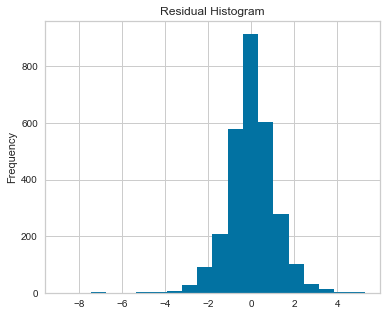

In [84]:
fig, ax = plt.subplots(figsize=(6,5))
resids = y_test-best_rfr.predict(X_test)
pd.Series(resids, name="residuals").plot.hist(bins=20, ax=ax, title="Residual Histogram")
resids_list=resids.tolist()
resids_mean=mean(resids_list)
resids_stdev=stdev(resids_list)
resids_array = np.array(resids_list)
st.t.interval(0.95, len(resids_array)-1, loc=np.mean(resids_array), scale=st.sem(resids_array))

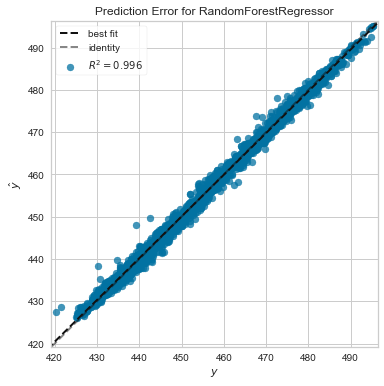

In [59]:
fig,ax = plt.subplots(figsize=(6,6))
pev = PredictionError(best_rfr)
pev.fit(X_train,y_train)
pev.score(X_test,y_test)
pev.poof()

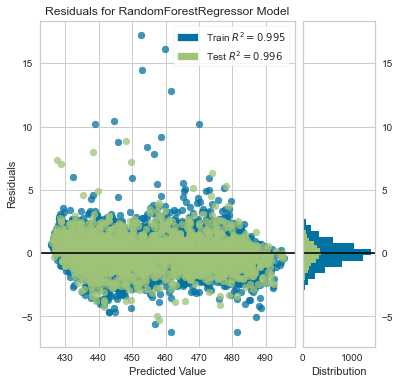

In [60]:
fig,ax = plt.subplots(figsize=(6,6))
rpv = ResidualsPlot(best_rfr)
rpv.fit(X_train,y_train)
rpv.score(X_test,y_test)
rpv.poof()

 <b>4.5 Residuals for best linear regression model <b/>

In [62]:
best_lr=model2

(-0.13219031787266694, 0.1934607747092279)

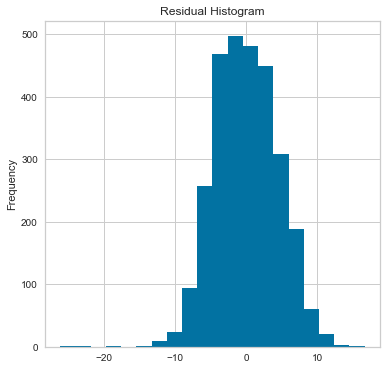

In [85]:
fig, ax = plt.subplots(figsize=(6,6))
resids = y_test-best_lr.predict(X_test)
pd.Series(resids, name="residuals").plot.hist(bins=20, ax=ax, title="Residual Histogram")
resids_list=resids.tolist()
resids_mean=mean(resids_list)
resids_stdev=stdev(resids_list)
resids_array = np.array(resids_list)
st.t.interval(0.95, len(resids_array)-1, loc=np.mean(resids_array), scale=st.sem(resids_array))

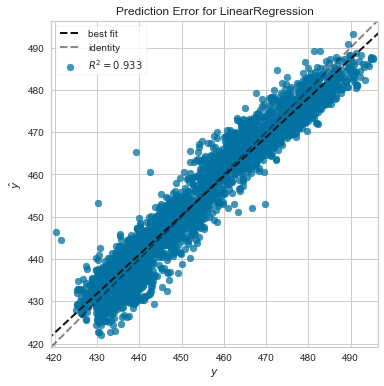

In [64]:
fig,ax = plt.subplots(figsize=(6,6))
pev = PredictionError(best_lr)
pev.fit(X_train,y_train)
pev.score(X_test,y_test)
pev.poof()

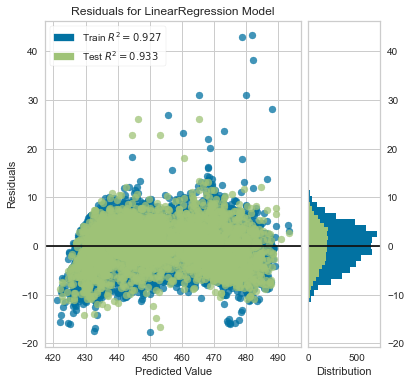

In [65]:
fig,ax = plt.subplots(figsize=(6,6))
rpv = ResidualsPlot(best_lr)
rpv.fit(X_train,y_train)
rpv.score(X_test,y_test)
rpv.poof()